We simulated data to find out how PAC arises with different parameters, and how the parameters affect each other.

    1) Simulate sinusoid
    2) 'Roll' sinusoid to not have same phase every time
    2) Add brown noise
    3) For each cycle, create (a wider or more narrow - or a uniform) distribution from which samples are taken to define the location of HF activity
    4) For each HF activity (100 per cycle) simulate a sinusoid (80-250Hz) and add to cycle of signal
    5) use FOOOF, ByCycle, and measure PAC


For each signal parameters are randomly chosen from these options:

    1) Frequency:           [10]                      Hz  
    
Ideally, we would pick a random number between 4 and 24 Hz as LF, but not possible with current ByCycle yet

    2) Brown noise slope:   [-2 : -1.5]               Exp
    
We cannot to up to -3 exp for brown noise, because there not enough power in the PSD and will be highly effected by adding HF's 

    3) Firing distribution  [.05 - .29 & uniform]   The STD of distributioin 0-1 with mean .5
    4) HF activity          [80 : 250]              Hz
    
In the end, we have four groups:

    1) Sinusoids + (more or less) phase-locked HF activity 
    2) Nonsinusoids + (more or less) phase locked HF activity
    3) Sinusoids + uniform HF activity
    4) Nonsinusoids + uniform HF activity

What we expect:

    1) In group 3 we expect the least PAC and least correlations between PAC and shape and PSD measures. 
    2) In group 2 might be highest PAC, but possibly only if the rdsym of nonsinusoids lines up with the HF activity (so maybe only just some channels with really high PAC
    3) In both group 1 and group 4 we expect PAC and their interactions with shape. This would imply that PAC & shape can be caused by both nonsinusoidal waveform shape, and HF activity (that will also alter nonsinusoidal waveform shape).


In [49]:
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import scipy.stats as stats


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [50]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
simulation_features_full = pd.read_csv('simulation_features_2_0_0_uniform.csv', sep=',')
simulation_features_full = simulation_features_full.dropna()

In [51]:
# create absolute values for symmetry measures
simulation_features_full['rdsym_abs'] = abs(simulation_features_full['rdsym'] - .5)
simulation_features_full['ptsym_abs'] = abs(simulation_features_full['ptsym'] - .5)
simulation_features_full['asine_rdsym'] = abs(simulation_features_full['asine_rdsym'] - .5)

In [52]:
# create two groups, nonsinusoid and sinusoid
simulation_features_sine_uni = simulation_features_full[(simulation_features_full['asine_rdsym']==0) &
                                                       (simulation_features_full['firing_std']==1)]
simulation_features_asine_uni = simulation_features_full[(simulation_features_full['asine_rdsym']!=0) &
                                                       (simulation_features_full['firing_std']==1)]

group_name = ['sinusoids with uniform HFs', 'nonsinusoids with uniform HFs']

In [53]:
print(simulation_features_asine_uni['pac_rhos'].median())
print(simulation_features_sine_uni['pac_rhos'].median())

0.019697596833882038
0.01748853811651501


In [54]:
# list for four groups
simulation_features_list = [simulation_features_sine_uni, simulation_features_asine_uni]

# Percent of signals having PAC

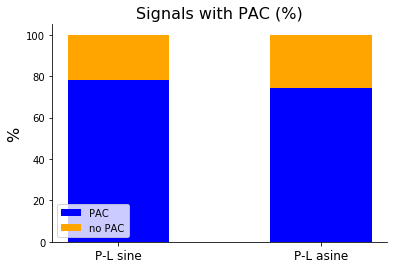

In [55]:
fig, ax = plt.subplots()
idx = np.arange(len(simulation_features_list))
for gr in range(len(simulation_features_list)):
    
    simulation_features = simulation_features_list[gr]

    menMeans = len(simulation_features[simulation_features['pac_presence']=='1']) / len(simulation_features) * 100
    womenMeans = len(simulation_features[simulation_features['pac_presence']=='0']) / len(simulation_features) * 100
    width = 0.5       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(gr+0.5, menMeans, width, color='blue')
    p2 = plt.bar(gr+0.5, womenMeans, width,
                 bottom=menMeans, color='orange')

plt.ylabel('%', size=16)
plt.title('Signals with PAC (%)', size=16)
plt.xticks(idx +.5, ('P-L sine', 'P-L asine', 'Uni sine', 'Uni asine'), size=12)
plt.legend(['PAC', 'no PAC'], loc='lower left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Correlation matrices

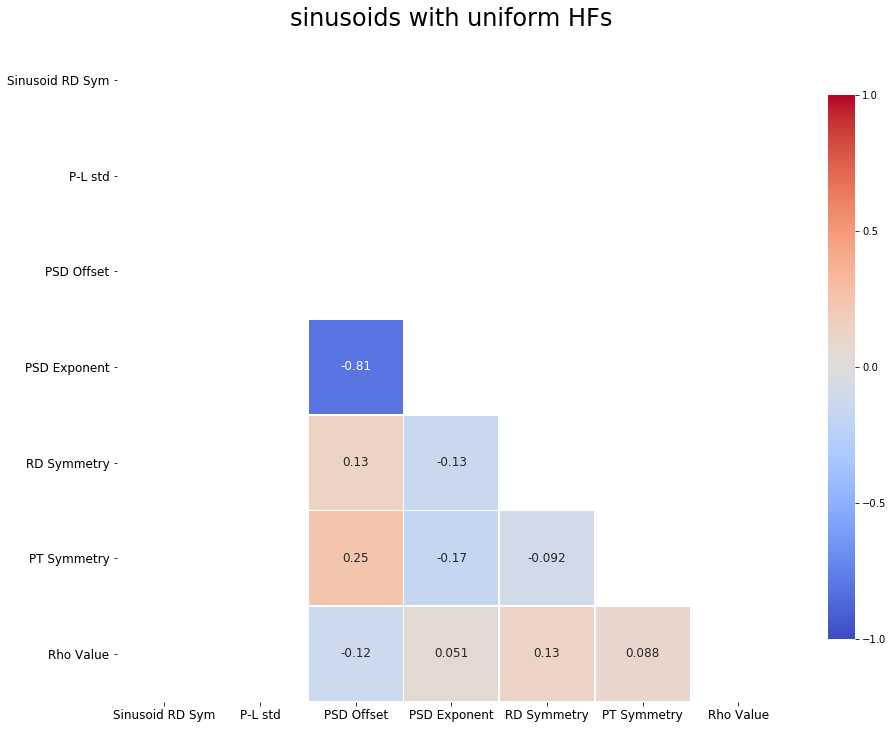

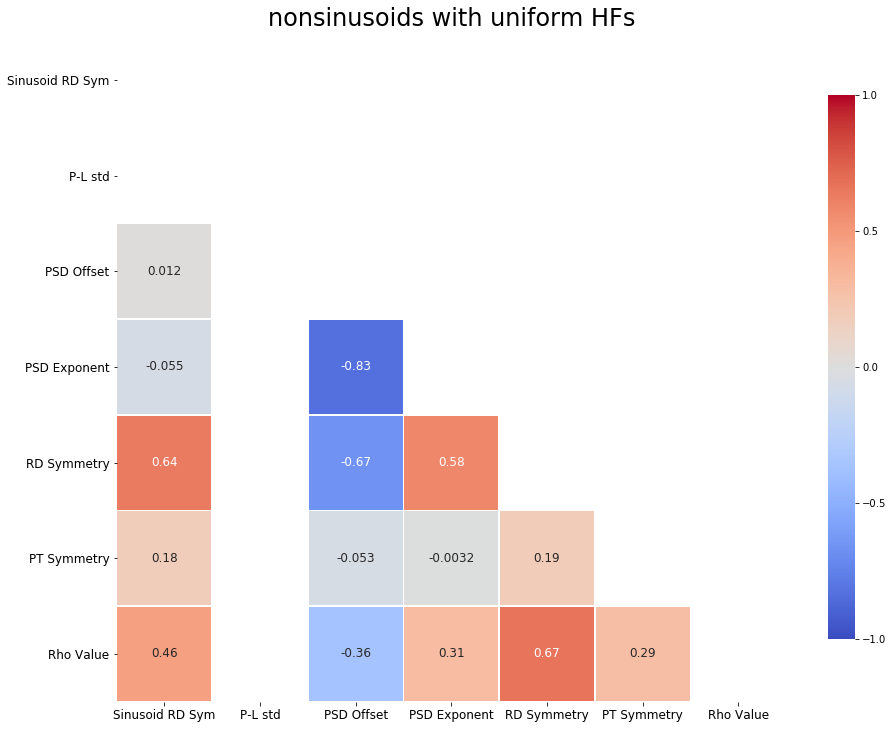

In [56]:
features_name = ['Sinusoid RD Sym', 'P-L std', 'PSD Offset', 'PSD Exponent', 'RD Symmetry', 'PT Symmetry', 'Rho Value']

for gr in range(len(simulation_features_list)): 
    
    simulation_features = simulation_features_list[gr]
    
    #### first create new dataframe with only the features we want to plot
    corr_features_df = simulation_features[['asine_rdsym', 'firing_std',
           'offset', 'exp', 'rdsym_abs', 'ptsym_abs', 'pac_rhos']].copy()

    corr_matrix = corr_features_df.corr()

    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    f, ax = plt.subplots(figsize=(15, 20))

    heatmap = sns.heatmap(corr_matrix,
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'coolwarm',
                          cbar_kws = {'shrink': .5,
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                          vmin = -1,
                          vmax = 1,
                          annot = True,
                          annot_kws = {'size': 12})

    #add the column names as labels
    ax.set_yticklabels(features_name, rotation = 0, size=12)
    ax.set_xticklabels(features_name, size=12)

    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
    ax.set_title(group_name[gr], size=24)

 <div class="alert alert-success">
Possible other analysis: 1) do more analysis on the differences between sinusoids + phase-locked distribution, and nonsinusoids + uniform distribution 2) split exponent up in two groups: lower and higher, to more clearly see effect of exponent, also on other features such as asymmetry. 3) differences between sinusoids and nonsinusoids in uniform distributions

</div>

# Uniform HF activity regression on Rho value

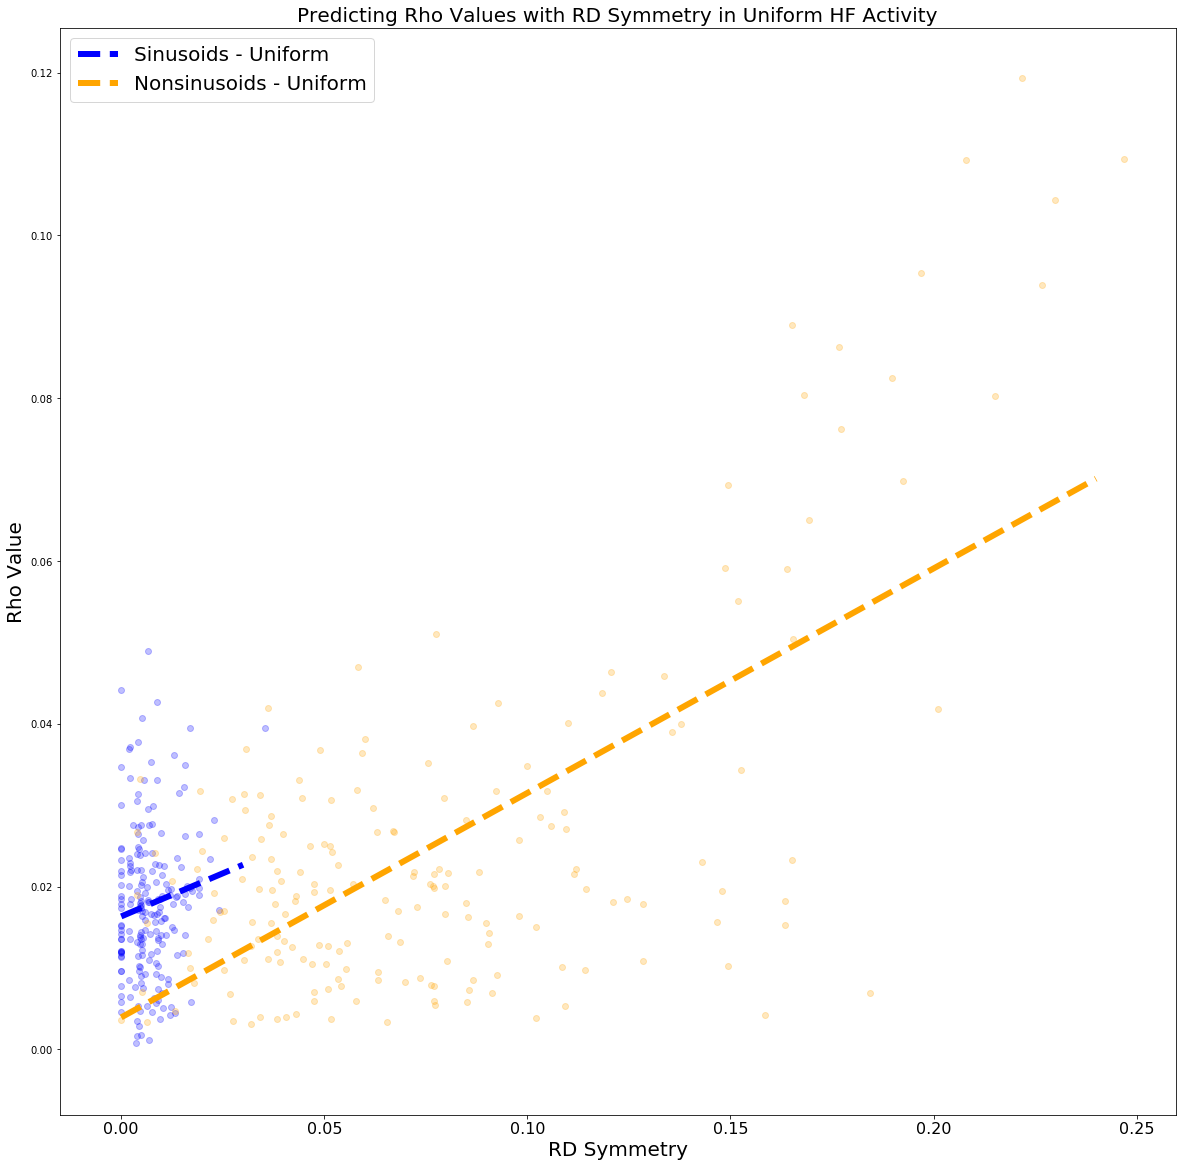

In [57]:
color_gr = ['blue', 'orange']

fig = plt.figure(figsize=(20,20))


for gr in range(len(simulation_features_list)): 
    
    simulation_features = simulation_features_list[gr]
    
   
    kwargs = dict(alpha=0.2, density=True, bins=12)
    # shape uni rhos and feature
    
    pac_rhos_uni = simulation_features['pac_rhos'].values.reshape(-1,1)
    feature_uni = simulation_features['rdsym_abs'].values.reshape(-1,1)

    # Uniform scatter
    plt.scatter(simulation_features['rdsym_abs'],
                simulation_features['pac_rhos'],
               color=color_gr[gr], alpha =.25)

    # Reg Uni
    reg2 = linear_model.LinearRegression()
    reg2.fit(feature_uni, pac_rhos_uni)
    xs = np.arange(min(feature_uni), max(feature_uni),0.01)
    ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
    plt.plot(xs, ys, '--', color=color_gr[gr], linewidth=6, alpha=1)

    plt.title('Predicting Rho Values with RD Symmetry in Uniform HF Activity', fontsize=20)
    plt.xlabel('RD Symmetry', fontsize=20)
    plt.ylabel('Rho Value', fontsize=20)
    plt.xticks(size=16)
    plt.xticks(size=16)
    plt.legend(['Sinusoids - Uniform', 'Nonsinusoids - Uniform'],fontsize=20)
    
plt.show()

In [58]:
simulation_features['rdsym_abs']

2      0.048872
5      0.149419
7      0.008232
9      0.109110
10     0.104732
         ...   
390    0.040641
392    0.019494
394    0.121150
395    0.163462
396    0.148596
Name: rdsym_abs, Length: 198, dtype: float64